In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# 1. Load Data

In [ ]:
df = pd.read_csv('Gabungann_final.csv')

# 2. Feature Engineering

**Mengurutkan berdasarkan waktu**

In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.sort_values(by='timestamp')

**Hitung selisih waktu dengan paket sebelumnya**

In [ ]:
df['time_diff'] = df.groupby('src_ip')['timestamp'].diff().dt.total_seconds().fillna(0)

**Fitur Pola Port**

In [ ]:
df['src_port'] = pd.to_numeric(df['src_port'], errors='coerce')
df['dst_port'] = pd.to_numeric(df['dst_port'], errors='coerce')


# Cek dst_port sama dengan baris sebelumnya
df['same_dst_port'] = (df.groupby('src_ip')['dst_port'].diff() == 0).astype(int)
# Cek src_port berubah
df['diff_src_port'] = (df.groupby('src_ip')['src_port'].diff() != 0).astype(int)

**Rolling Count (Hitung frekuensi serangan dalam 1 detik terakhir)**

In [ ]:
df_indexed = df.set_index('timestamp')
df['pkt_rate_1s'] = (
    df
    .groupby(['src_ip', df['timestamp'].dt.floor('1s')])['src_port']
    .transform('count')
)


--- Distribusi Data Serangan (Sebelum Split) ---
  Teknik Serangan (MITRE)  Jumlah Sampel Persentase
0                   T1499           3335     38.48%
1                   T1595           2197     25.35%
2                  Benign           1975     22.79%
3                   T1083            485       5.6%
4                   T1110            375      4.33%
5                   T1059            300      3.46%


/tmp/ipython-input-2592355177.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Jumlah Sampel', y='Teknik Serangan (MITRE)', data=jumlah_data, palette='viridis')


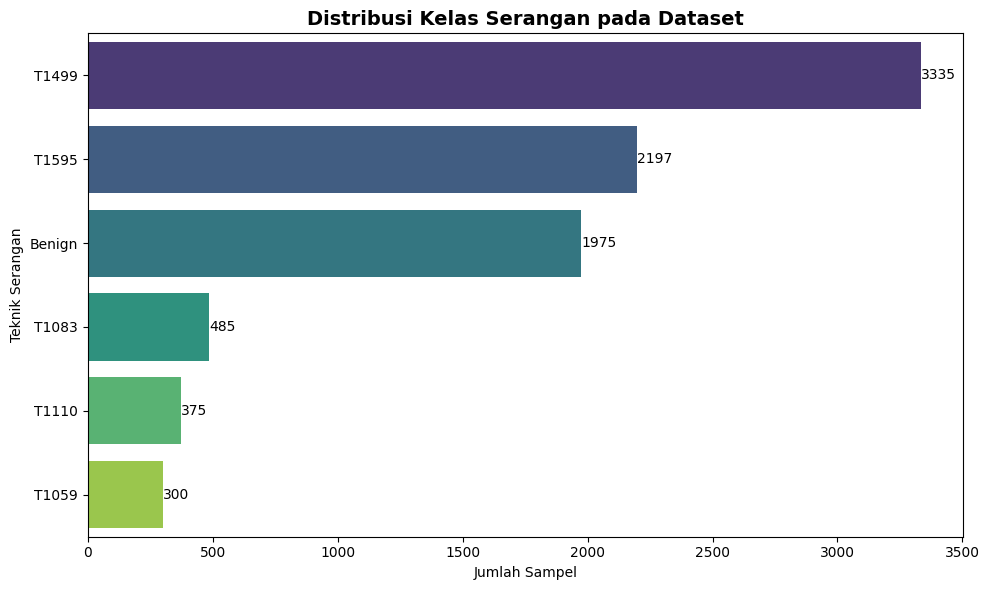

In [ ]:
# ==========================================
# CEK DISTRIBUSI DATA (SEBELUM SPLIT)
# ==========================================

# 1. Hitung jumlah data per label
jumlah_data = df['mitre'].value_counts().reset_index()
jumlah_data.columns = ['Teknik Serangan (MITRE)', 'Jumlah Sampel']

# 2. Hitung Persentase
total_data = len(df)
jumlah_data['Persentase'] = (jumlah_data['Jumlah Sampel'] / total_data) * 100
jumlah_data['Persentase'] = jumlah_data['Persentase'].round(2).astype(str) + '%'

print("\n--- Distribusi Data Serangan (Sebelum Split) ---")
print(jumlah_data)

# VISUALISASI
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='Jumlah Sampel', y='Teknik Serangan (MITRE)', data=jumlah_data, palette='viridis')
plt.title('Distribusi Kelas Serangan pada Dataset', fontsize=14, weight='bold')
plt.xlabel('Jumlah Sampel')
plt.ylabel('Teknik Serangan')

# Tambahkan angka di ujung bar
for index, value in enumerate(jumlah_data['Jumlah Sampel']):
    plt.text(value, index, str(value), va='center')

plt.tight_layout()
plt.show()

# 3. Preprocessing

In [ ]:
features_to_drop = ['timestamp', 'src_ip', 'dst_ip', 'mitre']


X = df.drop(columns=features_to_drop)

X['src_port'] = df['src_port']
X['dst_port'] = df['dst_port']

y = df['mitre']

le_proto = LabelEncoder()
X['protocol'] = le_proto.fit_transform(X['protocol'])

X = X.fillna(0)

print("Fitur yang digunakan model:", list(X.columns))

Fitur yang digunakan model: ['protocol', 'src_port', 'dst_port', 'time_diff', 'same_dst_port', 'diff_src_port', 'pkt_rate_1s']


# 4. Data Split

In [ ]:
# Tahap 1: Pisahkan data menjadi 80% Training dan 20% Sisanya (Temp)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Tahap 2: Pisahkan data "Sisanya" (20%) menjadi dua bagian sama rata
# 10% untuk Validation, 10% untuk Testing
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Jumlah Data Training   : {len(X_train)} baris (80%)")
print(f"Jumlah Data Validation : {len(X_val)} baris (10%)")
print(f"Jumlah Data Testing    : {len(X_test)} baris (10%)")

Jumlah Data Training   : 6933 baris (80%)
Jumlah Data Validation : 867 baris (10%)
Jumlah Data Testing    : 867 baris (10%)


# 5. Training Model

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'
)

rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

# 6. Evaluasi

In [ ]:
y_pred = rf_model.predict(X_temp)

print("\nClassification Report:")
print(classification_report(y_temp, y_pred, zero_division=0))

print("\nConfusion Matrix:")
print(confusion_matrix(y_temp, y_pred))

# Cek Feature Importance
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
print("\nFeature Importances:")
print(importances.sort_values(ascending=False))


Classification Report:
              precision    recall  f1-score   support

      Benign       0.99      1.00      1.00       395
       T1059       0.88      0.93      0.90        60
       T1083       0.96      0.93      0.94        97
       T1110       1.00      0.99      0.99        75
       T1499       1.00      0.99      1.00       667
       T1595       0.99      0.99      0.99       440

    accuracy                           0.99      1734
   macro avg       0.97      0.97      0.97      1734
weighted avg       0.99      0.99      0.99      1734


Confusion Matrix:
[[395   0   0   0   0   0]
 [  1  56   1   0   1   1]
 [  0   6  90   0   0   1]
 [  0   0   0  74   0   1]
 [  0   1   2   0 662   2]
 [  1   1   1   0   0 437]]

Feature Importances:
pkt_rate_1s      0.312938
src_port         0.188822
protocol         0.172019
dst_port         0.116199
time_diff        0.115915
diff_src_port    0.068496
same_dst_port    0.025610
dtype: float64


# 7. Grafik

In [ ]:
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12, 'font.family': 'sans-serif'})

# --- GRAFIK 1: FEATURE IMPORTANCE ---
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
# Gunakan palette warna yang kontras
barplot = sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')

plt.title('Feature Importance pada Model RF dengan log Suricata', fontsize=14, pad=20, weight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Fitur', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Menambahkan nilai angka di ujung bar
for i, v in enumerate(feature_importances['Importance']):
    barplot.text(v + 0.005, i, f'{v:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('skripsi_feature_importance.png', dpi=300) # Simpan resolusi tinggi
plt.show()

# --- GRAFIK 2: CONFUSION MATRIX ---
cm = confusion_matrix(y_temp, y_pred)
labels = sorted(y_temp.unique())

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels,
            cbar=False, annot_kws={"size": 14})

plt.title('Confusion Matrix Hasil Klasifikasi', fontsize=14, pad=20, weight='bold')
plt.xlabel('Label Prediksi', fontsize=12)
plt.ylabel('Label Sebenarnya', fontsize=12)
plt.tight_layout()
plt.savefig('skripsi_confusion_matrix.png', dpi=300)
plt.show()

# --- GRAFIK 3: DISTRIBUSI DATA TESTING ---
plt.figure(figsize=(10, 6))
sns.countplot(y=y_test, order=y_test.value_counts().index, palette='pastel')
plt.title('Distribusi Teknik Serangan pada Data Uji', fontsize=14, pad=20, weight='bold')
plt.xlabel('Jumlah Sampel', fontsize=12)
plt.ylabel('Teknik Serangan (MITRE ATT&CK)', fontsize=12)
plt.tight_layout()
plt.savefig('skripsi_class_distribution.png', dpi=300)
plt.show()

# Prediksi Data Baru

In [ ]:
df_new = pd.read_csv('suricata_testing.csv')

print("Jumlah data testing baru:", len(df_new))
df_new.head()
# ================================
# FEATURE ENGINEERING (KONSISTEN)
# ================================

df_new['timestamp'] = pd.to_datetime(df_new['timestamp'], errors='coerce')
df_new = df_new.sort_values(by='timestamp')

# Time difference
df_new['time_diff'] = (
    df_new.groupby('src_ip')['timestamp']
    .diff()
    .dt.total_seconds()
    .fillna(0)
)

# Port numeric
df_new['src_port'] = pd.to_numeric(df_new['src_port'], errors='coerce')
df_new['dst_port'] = pd.to_numeric(df_new['dst_port'], errors='coerce')

# Pola port
df_new['same_dst_port'] = (
    df_new.groupby('src_ip')['dst_port'].diff() == 0
).astype(int)

df_new['diff_src_port'] = (
    df_new.groupby('src_ip')['src_port'].diff() != 0
).astype(int)

# Packet rate 1 detik
df_new['pkt_rate_1s'] = (
    df_new
    .groupby(['src_ip', df_new['timestamp'].dt.floor('1s')])['src_port']
    .transform('count')
)
features_to_drop = ['timestamp', 'src_ip', 'dst_ip', 'gid', 'sid', 'rev', 'message', 'classification', 'priority', 'mitre']

X_new = df_new.drop(columns=features_to_drop, errors='ignore')

# Encode protocol pakai encoder LAMA
X_new['protocol'] = le_proto.transform(X_new['protocol'])

# Pastikan tidak ada NaN
X_new = X_new.fillna(0)

print("Fitur data testing:")
print(list(X_new.columns))
y_pred_new = rf_model.predict(X_new)

df_new['predicted_mitre'] = y_pred_new

df_new[['src_ip', 'dst_ip', 'predicted_mitre']].head()
df_new.to_csv('hasil_prediksi_testing.csv', index=False)
print("Hasil prediksi disimpan ke hasil_prediksi_testing.csv")


Jumlah data testing baru: 3429
Fitur data testing:
['protocol', 'src_port', 'dst_port', 'time_diff', 'same_dst_port', 'diff_src_port', 'pkt_rate_1s']
Hasil prediksi disimpan ke hasil_prediksi_testing.csv


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = df_new['mitre']

print("\n=== CLASSIFICATION REPORT (DATA TESTING BARU) ===")
print(classification_report(y_true, y_pred_new, zero_division=0))



=== CLASSIFICATION REPORT (DATA TESTING BARU) ===
              precision    recall  f1-score   support

      Benign       1.00      0.67      0.80         6
       T1059       0.89      1.00      0.94        40
       T1083       0.96      0.95      0.95        76
       T1110       1.00      1.00      1.00       225
       T1499       1.00      0.99      0.99      1153
       T1595       0.99      1.00      1.00      1929

    accuracy                           0.99      3429
   macro avg       0.97      0.93      0.95      3429
weighted avg       0.99      0.99      0.99      3429



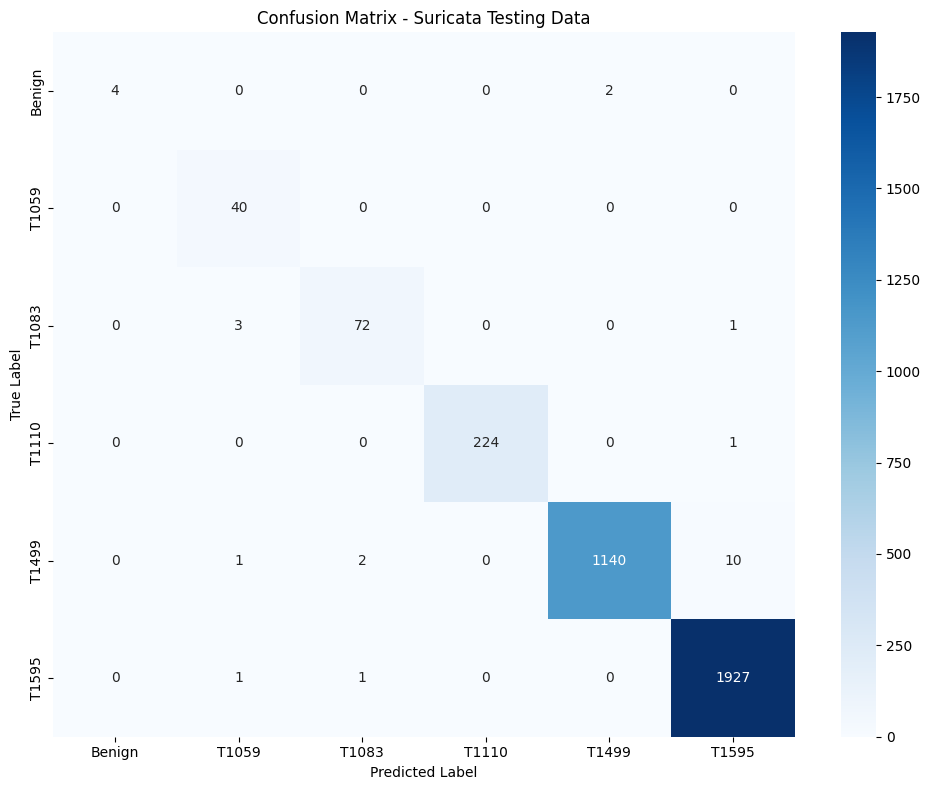

In [ ]:
labels = sorted(y_true.unique())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_new, labels=labels)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels
)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Suricata Testing Data')
plt.tight_layout()
plt.show()


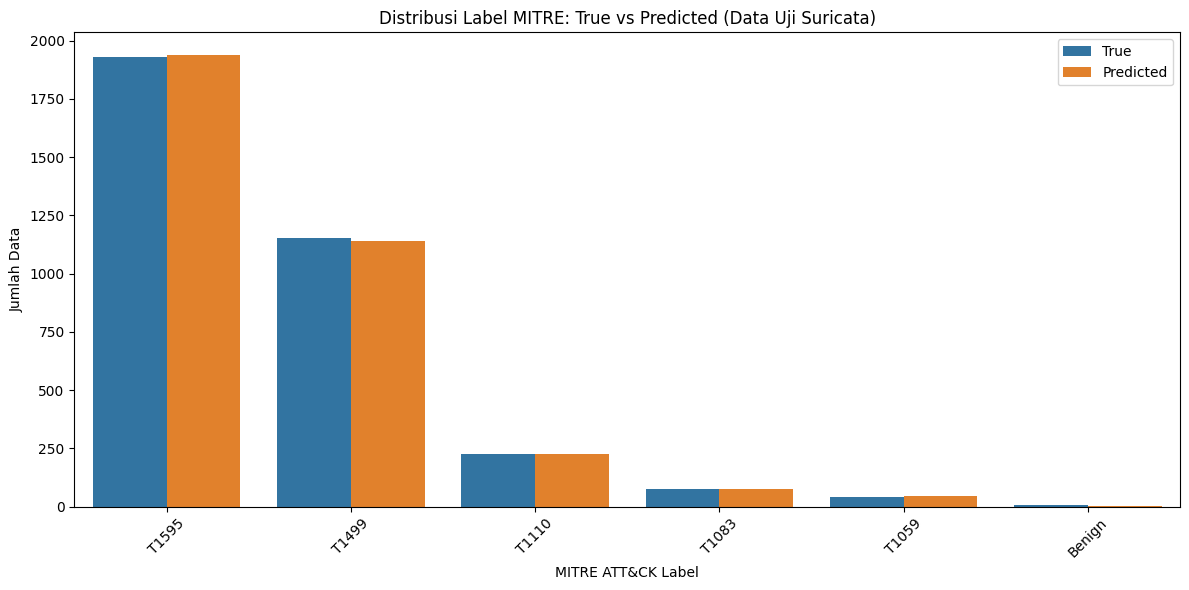

In [ ]:
df_compare = pd.DataFrame({
    'MITRE': df_new['mitre'],
    'Type': 'True'
})

df_pred = pd.DataFrame({
    'MITRE': y_pred_new,
    'Type': 'Predicted'
})

df_plot = pd.concat([df_compare, df_pred])

# Plot
plt.figure(figsize=(12, 6))
sns.countplot(
    data=df_plot,
    x='MITRE',
    hue='Type',
    order=df_plot['MITRE'].value_counts().index
)

plt.title('Distribusi Label MITRE: True vs Predicted (Data Uji Suricata)')
plt.xlabel('MITRE ATT&CK Label')
plt.ylabel('Jumlah Data')
plt.xticks(rotation=45)
plt.legend(title='')
plt.tight_layout()
plt.show()


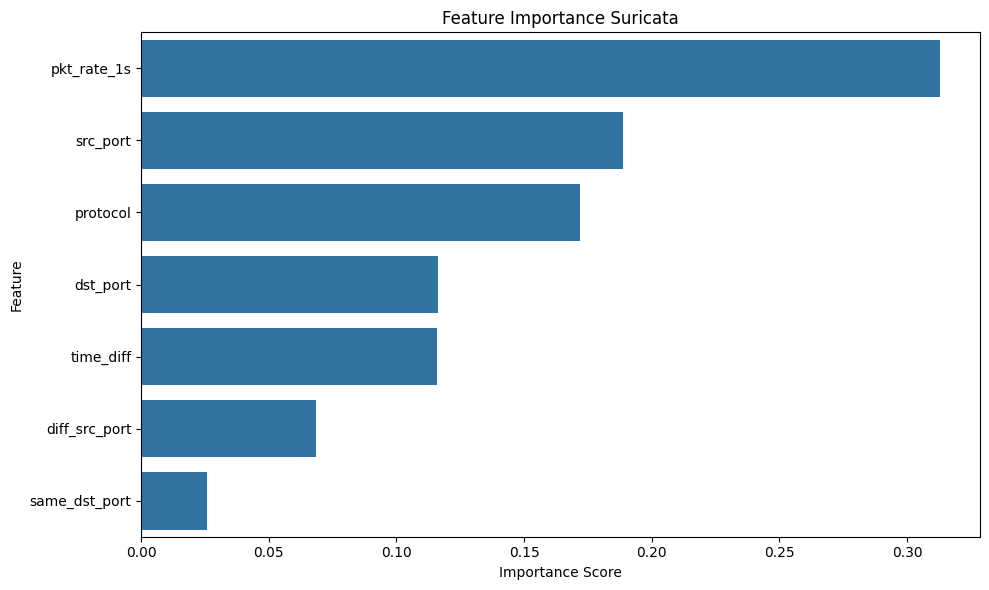

In [ ]:
importances = rf_model.feature_importances_

# Buat DataFrame
df_importance = pd.DataFrame({
    'Feature': X_new.columns,
    'Importance': importances
})

# Urutkan dari yang paling penting
df_importance = df_importance.sort_values(
    by='Importance',
    ascending=False
)

# Ambil top-N (opsional, misalnya 15 fitur teratas)
TOP_N = 15
df_top = df_importance.head(TOP_N)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_top,
    x='Importance',
    y='Feature'
)

plt.title('Feature Importance Suricata')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [ ]:
# Hitung distribusi label asli
dist_true = df_new['mitre'].value_counts().reset_index()
dist_true.columns = ['MITRE_Technique', 'Jumlah']

# Hitung persentase
dist_true['Persentase (%)'] = (
    dist_true['Jumlah'] / dist_true['Jumlah'].sum() * 100
).round(2)

print("\n=== Distribusi Teknik Serangan (Label Asli) ===")
print(dist_true.to_string(index=False))



=== Distribusi Teknik Serangan (Label Asli) ===
MITRE_Technique  Jumlah  Persentase (%)
          T1595    1929           56.26
          T1499    1153           33.62
          T1110     225            6.56
          T1083      76            2.22
          T1059      40            1.17
         Benign       6            0.17
